# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [1.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [15]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from abc import abstractmethod, ABC
import matplotlib.pyplot as plt
from typing import List
import numpy as np


'''
Informacje o przyjętej notacji
- zmienne z dużej litery nie oznaczają stałych
- X - macierz wartości neuronów | np. 64x1437
- Y - lista etykiet, które odpowiadają obrazom | np. 1437x1
- Z - macierz X pomnożona przez odpowidnie wagi i z dodaniem biasu | np. 10x1437
- A - macierz Z po przepuszczeniu przez funkcje aktywacji | np. 10x1437
- W - macierz wag danej warstwy | np. 10x64
- b - przesunięcie warstwy, charakterystyczny dla pojedycznego neuronu w wartstwie,
też macierz, jego długość zależy od liczby neuronów wyjściowych z danej warstwy | np. 10x1
- dW - pochodna funkcji kosztu względem wag | np. 10x64
- db - pochodna funkcji kosztu względem biasu | np. 10x1
- dZ - pochodna funkcji kosztu względem danej macierzy Z | np. 10x1437
'''

digits = load_digits()

pixels = digits.data
pixels = np.array([matrix / 16.0 for matrix in pixels])
numbers = digits.target

pixels_train, pixels_test, numbers_train, numbers_test = train_test_split(pixels, numbers, test_size=0.2,
                                                                          random_state=123)
# vector of the image is now a single column
pixels_train = pixels_train.T
pixels_test = pixels_test.T
m = numbers_train.size

In [25]:
class Layer(ABC):
    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def backward(self, output_error_derivative) -> np.ndarray:
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int,
                 m_train_size: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.Loss = MseLoss(m_train_size)

        self.weights = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.random.rand(output_size, 1) - 0.5

    def forward(self, X: np.ndarray) -> np.ndarray:
        Z = self.weights.dot(X) + self.bias
        return Z

    def backward(self, X: np.ndarray, dZ: np.ndarray
                 ) -> tuple[np.ndarray, np.ndarray]:
        dW = self.Loss.calc_cost_derivative_with_weights(dZ, X)
        db = self.Loss.calc_cost_derivative_with_bias(dZ)

        return dW, db

    def update_with_gradient_descent_step(self, dW: np.ndarray, db: np.ndarray
                                          ) -> tuple[np.ndarray, np.ndarray]:
        self.weights = self.weights - self.learning_rate * dW
        self.bias = self.bias - self.learning_rate * db

        return self.weights, self.bias


class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def _tanh_deriv(self, z: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(z) ** 2

    def forward(self, Z: np.ndarray) -> np.ndarray:
        A = np.tanh(Z)
        return A

    def backward(self, Z_before: np.ndarray, dZ2: np.ndarray, W2: np.ndarray) -> np.ndarray:
        """The returned value is the PREVIOUS dZ
        (e.g. if you use Z1, dZ2, W2 in arguments, you will get dZ1)"""
        dZ = W2.T.dot(dZ2) * self._tanh_deriv(Z_before)
        return dZ

    def backward_last_layer(self, A_last: np.ndarray, Y: np.ndarray) -> np.ndarray:
        dZ = A_last - MseLoss.get_perfect_clasification(Y)
        return dZ


class MseLoss:
    def __init__(self, m_train_size: int) -> None:
        self.m = m_train_size

    def loss(self, A: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return (1 / (2 * self.m)) * np.sum((A - self.get_perfect_clasification(Y))**2)

    def calc_cost_derivative_with_bias(self, dZ: np.ndarray) -> np.ndarray:
        return 1 / self.m * np.sum(dZ, axis=1, keepdims=True)

    def calc_cost_derivative_with_weights(self, dZ: np.ndarray, A: np.ndarray):
        return 1 / self.m * dZ.dot(A.T)

    @staticmethod
    def get_perfect_clasification(Y: np.ndarray) -> np.ndarray:
        perfect_Y = np.zeros((Y.size, Y.max() + 1))
        perfect_Y[np.arange(Y.size), Y] = 1
        perfect_Y = perfect_Y.T
        return perfect_Y


class Network:
    def __init__(self, layers: List[Layer], *, learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate

    def feed(self, X: np.ndarray) -> np.ndarray:
        previous_result = X
        for layer in self.layers:
            previous_result = layer.forward(previous_result)

        return self.get_predictions(previous_result)

    def get_predictions(self, A2: np.ndarray):
        return np.argmax(A2, 0)

    def get_accuracy(self, predictions: np.ndarray, Y: np.ndarray) -> float:
        return np.sum(predictions == Y) / Y.size

    def train(self,
              x_train: np.ndarray,
              y_train: np.ndarray,
              epochs: int,
              *, verbose: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

        layer1: FullyConnected = self.layers[0]
        layer1_5: Tanh = self.layers[1]
        layer2: FullyConnected = self.layers[2]
        layer2_5: Tanh = self.layers[3]
        weights1, b1, weights2, b2 = [None] * 4

        for i in range(epochs):
            Z1 = layer1.forward(x_train)
            A1 = layer1_5.forward(Z1)
            Z2 = layer2.forward(A1)
            A2 = layer2_5.forward(Z2)

            dZ2 = layer2_5.backward_last_layer(A2, y_train)
            dW2, db2 = layer2.backward(A1, dZ2)
            dZ1 = layer1_5.backward(Z1, dZ2, layer2.weights)
            dW1, db1 = layer1.backward(x_train, dZ1)

            weights1, b1 = layer1.update_with_gradient_descent_step(dW1, db1)
            weights2, b2 = layer2.update_with_gradient_descent_step(dW2, db2)

            if verbose and i % 50 == 0:
                print("Iteration: ", i)
                predictions = self.get_predictions(A2)
                print(self.get_accuracy(predictions, y_train))

        return weights1, b1, weights2, b2

    def train_one_layer(self,
                        x_train: np.ndarray,
                        y_train: np.ndarray,
                        epochs: int,
                        *, verbose: bool = True) -> tuple[np.ndarray, np.ndarray]:
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

        layer1: FullyConnected = self.layers[0]
        layer1_5: Tanh = self.layers[1]
        weights1, b1 = [None] * 2

        for i in range(epochs):
            Z1 = layer1.forward(x_train)
            A1 = layer1_5.forward(Z1)

            dZ1 = layer1_5.backward_last_layer(A1, y_train)
            dW1, db1 = layer1.backward(x_train, dZ1)

            weights1, b1 = layer1.update_with_gradient_descent_step(dW1, db1)

            if verbose and i % 50 == 0:
                print("Iteration: ", i)
                predictions = self.get_predictions(A1)
                print(self.get_accuracy(predictions, y_train))

        return weights1, b1

## Przykład procesu uczenia sieci o dwóch warstwach

In [ ]:
np.random.seed(1)

layer1 = FullyConnected(64, 10, m)
layer1_5 = Tanh()
layer2 = FullyConnected(10, 10, m)
layer2_5 = Tanh()
layers = [layer1, layer1_5, layer2, layer2_5]

network = Network(layers, learning_rate=0.1)
settings = network.train(pixels_train, numbers_train, 501, verbose=True)

## Przykład działania tej sieci

In [ ]:
predictions = network.feed(pixels_test)
precision = network.get_accuracy(predictions, numbers_test)
print(f"Prezycja na zbiorze testującym po nauce w 500 epokach wynosi {precision}")

## Demonstracja działania propagacji wstecznej na bramce XOR

### Nauka sieci do rozwiązywania problemu bramki XOR

In [ ]:
def demonstrate_XOR_gate(epochs: int) -> tuple[Network, tuple[
                                               np.ndarray, np.ndarray,
                                               np.ndarray, np.ndarray]]:
    X_xor = np.array([[0, 0],
                      [0, 1],
                      [1, 0],
                      [1, 1]])
    X_xor = X_xor.T
    Y_xor = np.array([0, 1, 1, 0])
    layer1 = FullyConnected(2, 2, Y_xor.size)
    layer1_5 = Tanh()
    layer2 = FullyConnected(2, 2, Y_xor.size)
    layer2_5 = Tanh()
    layers = [layer1, layer1_5, layer2, layer2_5]

    network = Network(layers, learning_rate=0.1)
    settings = network.train(X_xor, Y_xor, epochs, verbose=True)
    return network, settings

Poniżej możemy zaobserwować jak w kolejnych epokach sieć poprawia swoje ustawienia - wagi warstw i biasy, aby coraz mniej odbiegać od oczekiwanych rezultatów (funkcja strat). To jak bardzo nasza sieć polepsza swoje ustawienia w pojedynczej epoce zależy od learnig rate (w tym przypadku 0.1).

In [ ]:
np.random.seed(123)

network, settings = demonstrate_XOR_gate(5001)

## Jak działa klasyfikacja i propagacja wsteczna w sieci neuronowej na podstawie powyższego problemu

Ustawienia sieci (wagi, biasy) zostały ustawione na podstawie nauki jednej z sieci neuronowej w podobny sposób do tego powyżej. Poniższa sieć ma precyzje 1.0, to znaczy, że po przepuszczeniu każdych danych wejściowych: [0, 0], [0, 1], [1, 1], [1, 1], otrzymamy odpowiednio zakodowaną klasyfikację na wyjściu sieci.

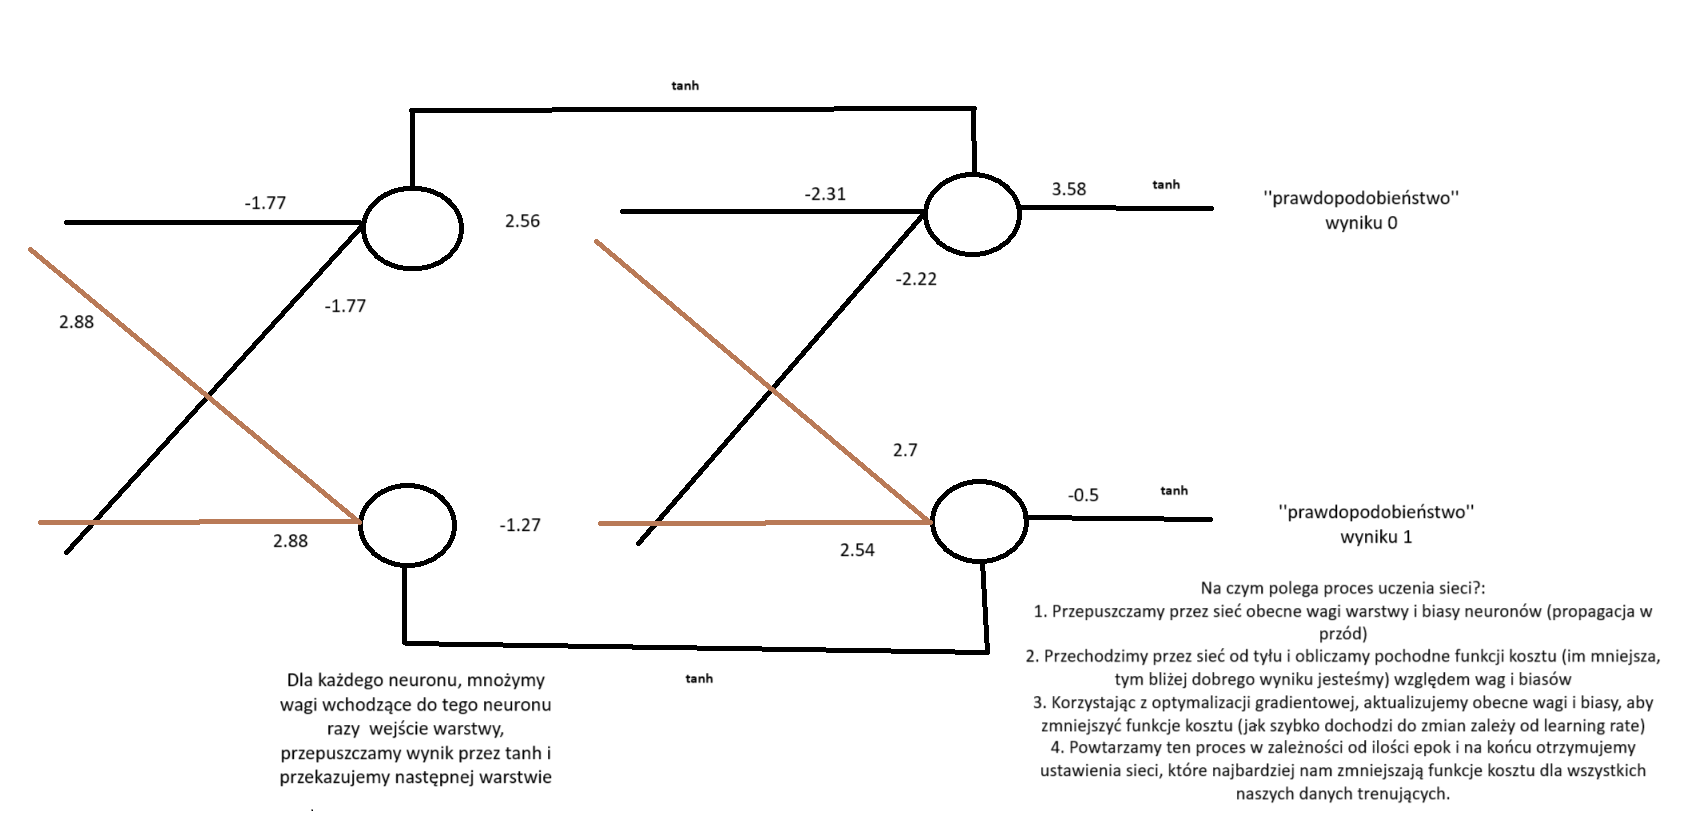

## Porównanie 1-warstwowej i 2-warstwowej sieci neuronowej

Poniższe testy zostały wykonywane na tych samych danych i z takimi samymi początkowymi ustawieniami wag i biasów w warstwach i z tym samym learning rate.

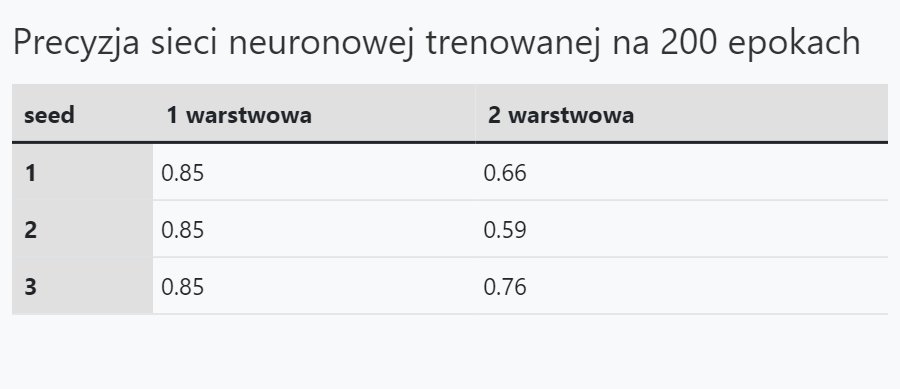



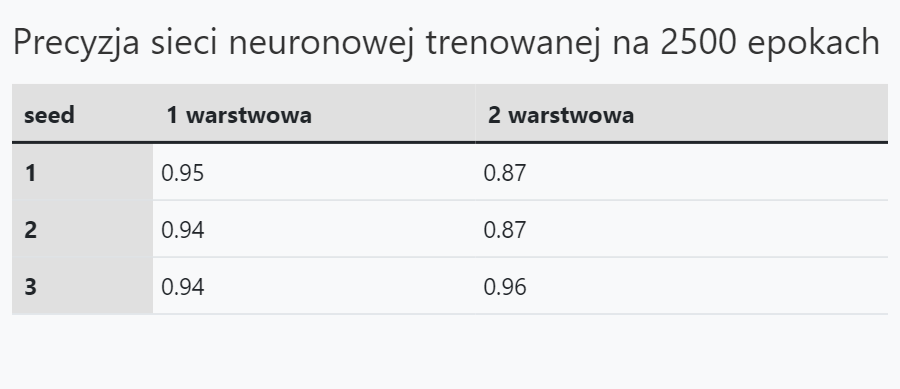

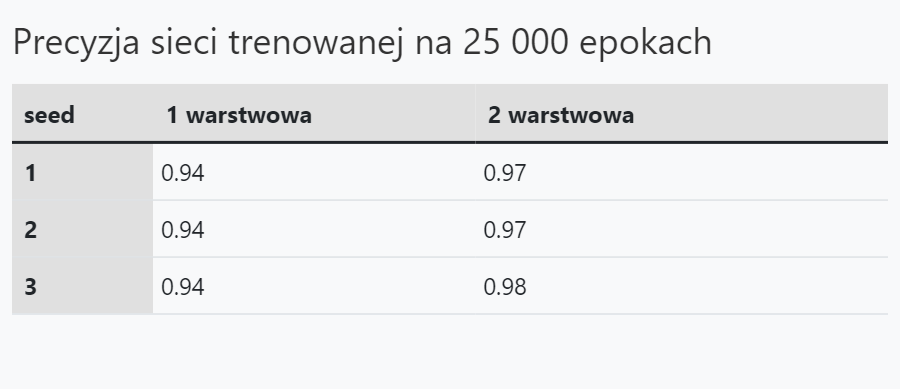

# Wnioski

### - to ile warstw sieci jest potrzebnych do osiągniecia zadowalających prezycji, jest zależne od danego problemu - dla klasyfikacji na zbiorze MNIST udawało się osiągać prezycję rzędu 0.95 na sieci jednowarstowej, dla problemu bramki XOR nie udało się osiągnąć prezycji większej niż 0.5 na sieci jednowarstwowej

### - 1-warstowa sieć neuronowa szybciej się uczy niż 2-warstwowa, ma mniej parametrów to optymalizacji

### - 2-warstwowa sieć przez to, że ma więcej parametrów do optymalizacji, jest w stanie lepiej dopasować się do zbioru danych wejściowych niż sieć 1-warstwowa

### - 1-warstowa sieć neuronowa działa zauważalnie szybciej w przypadku bardzo dużej ilości epok, wynika to z faktu, że sieć 2-warstwowa w każdej epoce ma więcej operacji do wykonania

### - uczenie sieci z bardzo dużą ilością epok i warstw może prowadzić do przeuczenia sieci przez nadmierne dopasowanie do zbioru trenującego